In [2]:
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

# Data Exploration

In this project, I will investigate the EUROSAT dataset. The EUROSAT collection is made up of photos obtained by the Sentinel-2 satellite. This dataset categorises photos of the earth's surface into ten distinct land cover classifications. For this project, I will create an image classification model to predict a land cover label from an image.

In [3]:
dataset = "./2750"

labels = os.listdir(dataset)
print(labels)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


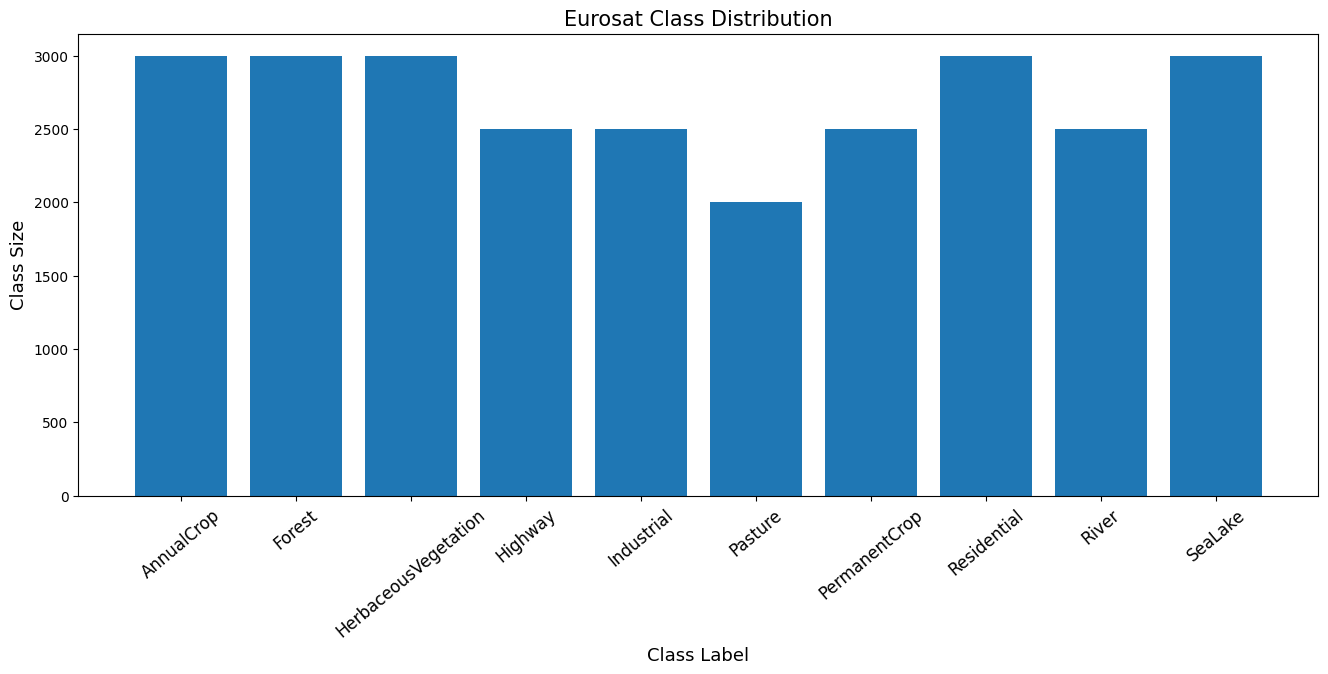

In [4]:
counts =  {}

for l in labels:
    counts[l] = len(os.listdir(os.path.join(dataset, l)))

plt.figure(figsize=(16, 6))
plt.bar(range(len(counts)), list(counts.values()), align= 'center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize = 12, rotation = 40)
plt.xlabel('Class Label', fontsize = 13)
plt.ylabel('Class Size', fontsize = 13)
plt.title('Eurosat Class Distribution', fontsize = 15);

The dataset is classified into ten types of land cover. Because each class is different in size, I'll need to stratify the data later when I divide it into training, testing, and validation sets.

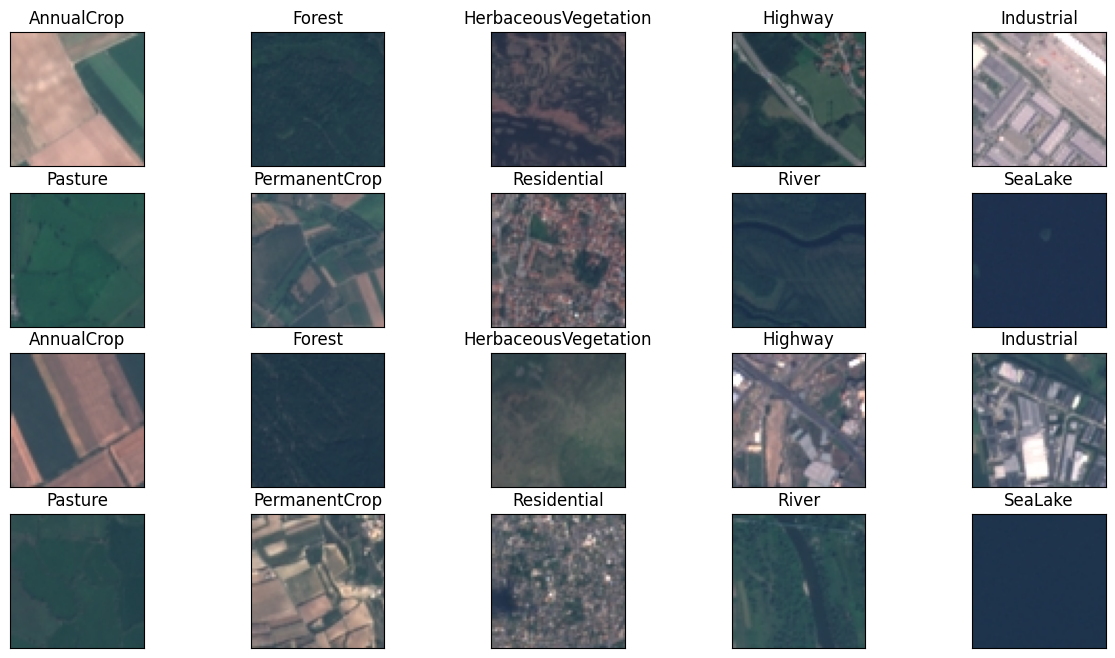

In [5]:
img_paths = [os.path.join(dataset, l, l+'_1000.jpg') for l in labels]

img_paths = img_paths + [os.path.join(dataset, l, l+'_2000.jpg') for l in labels]

def plot_images(paths):
    plt.figure(figsize = (15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks = [], yticks = [])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('\\')[-2])

plot_images(img_paths)

Examining the previews of various classes reveals both resemblances and marked distinctions among them.

Metropolitan settings such as Highway, Residential, and Industrial landscapes showcase architectural structures and, in some instances, road networks.

Both AnnualCrops and PermanentCrops exhibit agricultural terrain, distinguished by orderly demarcations delineating diverse crop fields.

Conversely, HerbaceousVegetation, Pasture, and Forest regions embody natural landscape features; though Rivers also fall within the natural category, their distinction from other natural classes may be more apparent.

Assessing the image content allows for the estimation of potential confusion between classes. For instance, a river image might be misconstrued as a highway, while a complex highway intersection surrounded by buildings could be mistaken for an Industrial site. Thus, a robust classifier is imperative to discern such nuances effectively.

Furthermore, Sentinel-2 satellite images offer the possibility of acquiring additional bands, including Near-Infrared Radiation bands. Although NIR data could facilitate the creation of radiation visualization indices, such as detecting the presence or absence of radiation within an image, the dataset at hand lacks NIR wavelength bands, precluding exploration of this option. Nonetheless, it's noteworthy that NIR data could offer an alternative approach to addressing this classification challenge.

# Preprocessing


I plan to assess the model's performance post-training by employing a stratified shuffle-split method via Scikit-learn. This approach ensures that class proportions are preserved, with 30% of the dataset reserved for evaluation. Each image will be categorized into its corresponding land cover directory.

Once the dataset is split, I'll utilize the ImageDataGenerator class in Keras to load the data into the model. To enhance the training process, I'll introduce image augmentations using the generator. Additionally, a subset of the training data will be allocated for validation purposes during training.

In [6]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

In [7]:
train_dir = "./training"
test_dir = "./testing"

In [8]:
Batch_size = 64
classes = len(labels)
input_shape = (64, 64, 3)
Class_mode = 'categorical'

In [9]:
for path in (train_dir, test_dir):
    if not os.path.exists(path):
        os.mkdir(path)

for l in labels:
    if not os.path.exists(os.path.join(train_dir, l)):
        os.mkdir(os.path.join(train_dir, l))
    
    if not os.path.exists(os.path.join(test_dir, l)):
        os.mkdir(os.path.join(test_dir, l))

In [10]:
data = {}

for l in labels:
    for img in os.listdir(dataset+'/'+l):
        data.update({os.path.join(dataset, l, img): l})

X = pd.Series(list(data.keys()))
Y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 69)

for train_idx, test_idx in split.split(X, Y):

    train_paths = X[train_idx]
    test_paths = X[test_idx]


    new_train_paths = [re.sub('./2750', './training', i) for i in train_paths]
    new_test_paths = [re.sub('./2750', './testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))

    print("Moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

    print("Moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])



Moving training files..


100%|██████████| 18900/18900 [00:01<00:00, 16719.38it/s]


Moving testing files..


100%|██████████| 8100/8100 [00:00<00:00, 18381.19it/s]


In [11]:
train_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 60,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True
)

train_generator = train_gen.flow_from_directory(
    directory = train_dir,
    target_size = (64, 64),
    batch_size = Batch_size,
    class_mode = Class_mode,
    color_mode = 'rgb',
    shuffle = True,
    seed = 69
)

test_gen = ImageDataGenerator(
    rescale = 1./255
)

test_generator = test_gen.flow_from_directory(
    directory = test_dir,
    target_size = (64, 64),
    batch_size = Batch_size,
    class_mode = Class_mode,
    color_mode = 'rgb',
    shuffle = False,
    seed = 69
)

Found 18900 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.


In [12]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [13]:
np.save('class_indices', train_generator.class_indices)

# Machine Learning for Image Classification

First, we'll evaluate the performance of a machine learning model by directly inputting the entire image pixels, which is 64x64x3 = 12,288 dimensions. We've split our dataset into training and test sets using a 70-30 split on the 27,000 samples, resulting in a training set of size 18,900 and a test set of size 8,100.

Next, we'll leverage Keras' ImageDataGenerator to preprocess the image dataset into a numpy array format suitable for training and testing machine learning models. This allows us to apply data augmentation techniques and efficiently feed the data to the model.

We'll start by testing a Random Forest Classifier using two implementations: one provided by scikit-learn directly, and another implemented from scratch. 

In [14]:
rf_gen = ImageDataGenerator(rescale = 1./255)

rf_train_generator = rf_gen.flow_from_directory(
    directory= train_dir,
    target_size= (64, 64),
    batch_size= 18900,
    class_mode=Class_mode,
    color_mode= 'rgb',
    shuffle= False,
    seed= 7
)

rf_test_generator = rf_gen.flow_from_directory(
    directory = test_dir,
    target_size= (64, 64),
    color_mode='rgb',
    class_mode= Class_mode,
    batch_size= 8100,
    shuffle= False,
    seed= 7
)

Found 18900 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.


In [15]:
train = rf_train_generator.next()
X_train = train[0].reshape(18900, 12288)
Y_train = train[1]

test = rf_test_generator.next()
X_test = test[0].reshape(8100, 12288)
Y_test = test[1]

## Random Forest

In [17]:
# Creating mini batches of training data as training on whole data is difficult

ds = np.random.choice(len(X_train), size = 18900, replace=False)

X_train_part1 = X_train[ds]
Y_train_part1 = rf_train_generator.classes[ds]

In [18]:
# import random forrest Classifier

from sklearn import ensemble
from sklearn.metrics import accuracy_score

rf_clf = ensemble.RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state= 7)
rf_clf.fit(X_train_part1, Y_train_part1)
y_pred = rf_clf.predict(X_test)

In [21]:
acc = accuracy_score(y_pred, rf_test_generator.classes)
print("Accuracy Score: {0:.2} ".format(acc))

Accuracy Score: 0.61 
